## 5th Cycle of Data Science Life Cycle
Here I add demand forecast as a feature

### Imports

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
    
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Business Understanding
* Exogenous factors:
    * Generation data (biomass, fossil fuels, wind, solar)
    * Load data (forecast or actual)
    * Weather data (temp, wind_speed, rain, humidity, preassure, clouds, snow)
    * Other prices data (fuel price, other market price...) 
***    
Some references:
<br>
Article about feature engineering techniques for time series data <a href='https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/' target="_blank">here</a>
<br>
Article about multivariate time series forecasting using random forests <a href="https://towardsdatascience.com/multivariate-time-series-forecasting-using-random-forest-2372f3ecbad1" target="_blank">here</a>. 
<br>
Kaggle notebook about electricity price forecasting with DNNs <a href="https://www.kaggle.com/dimitriosroussis/electricity-price-forecasting-with-dnns-eda" target="_blank">here</a>.
<br>
Kaggle notebook about time Series - Exploratory Data Analysis & Forecast <a href="https://www.kaggle.com/rgrajan/time-series-exploratory-data-analysis-forecast" target="_blank">here</a>.
<br>
Article about 'Statistical Modeling of Time Series Data Part 2: Exploratory Data Analysis' <a href="https://towardsai.net/p/data-visualization/statistical-modeling-of-time-series-data-part-2-exploratory-data-analysis" target="_blank">here</a>.
<br>
Article about 'How-To Guide on Exploratory Data Analysis for Time Series Data' <a href="https://medium.com/analytics-vidhya/how-to-guide-on-exploratory-data-analysis-for-time-series-data-34250ff1d04f" target="_blank">here</a>

### Data Collection

In [2]:
#Upload main dataset for hourly market prices from June 2020 to June 2021
data = pd.read_csv('Data/price_data.csv')

In [3]:
#Upload main dataset for weather forecast from June 2020 to June 2021
weather_data = pd.read_csv('Data/weather_data.csv')

In [4]:
# Create list with all sites dataframes
site_dataframes = []
#Upload each site's dataset for weather forecast from June 2020 to June 2021
site_names = weather_data.site_name.unique()
for i in site_names:
    name= i + '_data'
    name = pd.read_csv('Data/' + i + '.csv')
    site_dataframes.append(name)

In [5]:
# Upload 1 year lag dataset for weather forecast from June 2019 to June 2020
one_year_lag = pd.read_csv('Data/1_year_lag.csv')
one_year_lag = one_year_lag.rename(columns={'value': '1_year_lag'})

In [6]:
#Upload dataset for demand forecast from June 2020 to June 2021
demand_data = pd.read_csv('Data/demand_forecast.csv')

### Data Preparation

In [7]:
# Make sure that the days of the week of the lag and the real value are the same, 
# so shift from Sunday to Tuesday for first row
one_year_lag['1_year_lag'] = one_year_lag['1_year_lag'].shift(2).fillna({0: one_year_lag['1_year_lag'][6],
                                                                       1: one_year_lag['1_year_lag'][7]})

In [8]:
# Drop everything except the lag column
one_year_lag = one_year_lag.drop(columns=['date','start_time_uk'])

In [9]:
# Since 2020 was a leap-year, remove last column to match dataframes
one_year_lag = one_year_lag.drop(index=[360])

In [10]:
# Make a column with the index so that the two dataframes to be merged have something in common
one_year_lag['index'] = one_year_lag.index

In [11]:
# Convert dates and times to datetime in main dataframe
data['date'] = pd.to_datetime(data.date, format="%Y-%m-%d")
data['start_time_uk'] = pd.to_datetime(data.start_time_uk, 
                                       format='%H:%M:%S').dt.time

In [12]:
# Make a column with the index so that the two dataframes to be merged have something in common
data['index'] = data.index

In [13]:
# Merging the main data and the one year lag dataframe
data = data.merge(one_year_lag)

In [14]:
# Drop the index column that was created to match dataframes
data = data.drop(columns=['index'])

In [15]:
# Convert to datetime all sites dataframes
for df in site_dataframes:
    df['date'] = pd.to_datetime(df.date, format="%Y-%m-%d")
    df['start_time_uk'] = pd.to_datetime(df.start_time_uk, 
                                           format='%H:%M:%S').dt.time
    df.sort_values(by='date')

In [16]:
# Choose the only site that has data for all days
rheidol_data = site_dataframes[0]

In [17]:
# Merge the market prices data with the rheidol_data dataframe since they have same time and dates
data= data.merge(rheidol_data).drop(labels='site_name', axis=1, inplace=False)

In [18]:
# Sort by date the new dataframe
data.sort_values(by=['date'], ignore_index=True, 
                 inplace=True)

In [19]:
# Get deamand data ready to merge
demand_data = demand_data.rename(columns= {'index': 'date'})

In [20]:
demand_data['date'] = pd.to_datetime(demand_data.date, format="%Y-%m-%d")

In [21]:
# Merge the demand data with data dataframe since they have same dates
data= data.merge(demand_data)

In [22]:
# Make 'date' column the index of the dataframe, and convert it to datetime
data.index = data['date'].rename('index')
data.index = pd.to_datetime(data.index)

In [23]:
#Checking for missing dates, if any found, return to 'Data Collection' to add it
pd.date_range(start = '2020-06-30', end = '2021-06-24' ).difference(data.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [24]:
# Create functions to add new columns with day of week ,year and month and weekday/weekend.
def add_day_week(dataframe):
    dataframe['weekday'] = dataframe['date'].apply(lambda x: x.weekday())
    
def add_month(dataframe):
    dataframe['month'] = dataframe['date'].apply(lambda x: x.month)
    
def add_year(dataframe):
    dataframe['year'] = dataframe['date'].apply(lambda x: x.year)
    
def add_day_week_name(dataframe):
    dataframe['weekday_name'] = dataframe['date'].apply(lambda x: x.strftime('%A'))

def add_month_name(dataframe):
    dataframe['month_name'] = dataframe['date'].apply(lambda x: x.strftime('%B'))
    
def weekday_weekend(dataframe):
    dataframe['weekday_or_weekend'] = dataframe['date'].apply(lambda x: 1 if x.strftime('%A') in ('Saturday','Sunday') else 0)
    
def add_day_of_month(dataframe):
    dataframe['day_of_month'] = dataframe['date'].apply(lambda x: x.day)

In [25]:
# Add all the new day-related columns
add_day_week(data) #Day of the week (number)
add_month(data) #Month (number)
add_year(data) #Year 
add_day_week_name(data) #Day of the week (name)
add_month_name(data) #Month (name)
weekday_weekend(data) #Binary for weekday or weekend
add_day_of_month(data) #Day of month (number) (Could be deleted later if model is not as good as before)

In [26]:
# Drop date column now that we have all the information in columns
data.drop(labels='date', axis=1, inplace=True)

In [27]:
data.info()
print("Dataframe shape: ", data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2020-06-30 to 2021-06-24
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   value               360 non-null    float64
 1   start_time_uk       360 non-null    object 
 2   1_year_lag          360 non-null    float64
 3   temperature         360 non-null    float64
 4   snow                360 non-null    float64
 5   ground_pressure     360 non-null    float64
 6   humidity            360 non-null    float64
 7   wind_speed          360 non-null    float64
 8   rain                360 non-null    float64
 9   pressure            360 non-null    float64
 10  wind_deg            360 non-null    float64
 11  clouds              360 non-null    float64
 12  demand_1F           360 non-null    float64
 13  demand_1A           360 non-null    float64
 14  demand_1B           360 non-null    float64
 15  demand_2F           360 non-null    fl

In [28]:
# Print NaNs and duplicates in a dataframe
def NaN_duplicates(dataframe):
    print('There are {} missing values or NaNs in data.'
          .format(dataframe.isnull().values.sum()))

    duplicates_num = dataframe.duplicated(keep='first').sum()
    print('There are {} duplicate rows in data based on all columns.'
          .format(duplicates_num))

In [29]:
NaN_duplicates(data)

There are 0 missing values or NaNs in data.
There are 0 duplicate rows in data based on all columns.


In [30]:
# Build i day lag feature (revise after EDA)
def add_lag_feature(lag_num, column_to_lag, dataframe):
    """
    Adds one column to the data frame with some column's lagged values.
    Parameters:
    - lag_num: this is the number of lags we want, for example we can lag
        a column one day, two, three...
    - column_to_lag: this is the dataframe column we want to lag
    - dataframe: this is the dataframe to which we want to apply the lag function.
    """
    dataframe[str(lag_num) + '_day_lag'] = dataframe[column_to_lag].shift(lag_num).fillna(method='bfill')

In [31]:
# Add lag features
for i in range(1,14):
    add_lag_feature(i,'value', data)

In [32]:
# Functions to add standard moving average columns
def add_standard_moving_average(window, column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's standard moving average.
    Parameters:
    - window: this is the number of rows we average over.
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe[str(window) + '_std_moving_average'] = dataframe[column_to_average].rolling(window, min_periods=1).mean()
    
# Add expanding moving average 
def add_expanding_moving_average(column_to_average, dataframe):
    """
    Adds one column to the data frame with some column's expanding average.
    Parameters:
    - column_to_lag: this is the dataframe column we want to apply moving average to.
    - dataframe: this is the dataframe to which we want to apply the function.
    """
    dataframe['ex_moving_average'] = dataframe[column_to_average].expanding().mean()

In [33]:
# Add moving averages
add_standard_moving_average(15,'1_day_lag',data)
add_standard_moving_average(7,'1_day_lag',data)
add_standard_moving_average(3,'1_day_lag',data)
add_standard_moving_average(2,'1_day_lag',data)
add_expanding_moving_average('value',data)

### Exploratory Data Analysis
Description

In [34]:
data.columns.unique()

Index(['value', 'start_time_uk', '1_year_lag', 'temperature', 'snow',
       'ground_pressure', 'humidity', 'wind_speed', 'rain', 'pressure',
       'wind_deg', 'clouds', 'demand_1F', 'demand_1A', 'demand_1B',
       'demand_2F', 'demand_2A', 'demand_2B', 'demand_3B', 'demand_4B',
       'demand_4C', 'weekday', 'month', 'year', 'weekday_name', 'month_name',
       'weekday_or_weekend', 'day_of_month', '1_day_lag', '2_day_lag',
       '3_day_lag', '4_day_lag', '5_day_lag', '6_day_lag', '7_day_lag',
       '8_day_lag', '9_day_lag', '10_day_lag', '11_day_lag', '12_day_lag',
       '13_day_lag', '15_std_moving_average', '7_std_moving_average',
       '3_std_moving_average', '2_std_moving_average', 'ex_moving_average'],
      dtype='object')

<AxesSubplot:xlabel='Date', ylabel='Price(unit)'>

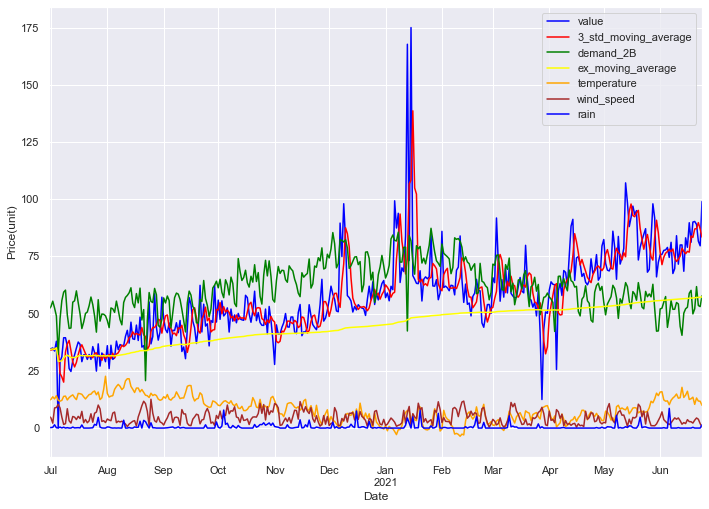

In [35]:
# Basic plot of time series and moving average.
data[['value','3_std_moving_average', 'demand_2B','ex_moving_average', 'temperature', 'wind_speed', 'rain']].plot(
    ylabel='Price(unit)', xlabel='Date', color=['blue', 'red','green', 'yellow', 'orange', 'brown'])

In [36]:
# Find correlation between features and price
correlations = data.corr(method='pearson')
print(correlations['value'].sort_values(ascending=False).to_string())

value                    1.000000
2_std_moving_average     0.785488
7_std_moving_average     0.778473
3_std_moving_average     0.773525
15_std_moving_average    0.753963
2_day_lag                0.737897
ex_moving_average        0.728102
1_day_lag                0.718286
7_day_lag                0.657840
year                     0.643790
5_day_lag                0.643352
3_day_lag                0.640728
6_day_lag                0.627235
4_day_lag                0.618285
8_day_lag                0.604600
9_day_lag                0.596019
13_day_lag               0.579868
11_day_lag               0.577927
10_day_lag               0.572215
12_day_lag               0.556936
demand_1B                0.443470
demand_1A                0.384296
demand_1F                0.376019
demand_4C                0.360218
demand_2F                0.332419
demand_2A                0.312375
demand_2B                0.286949
demand_3B                0.254871
demand_4B                0.223321
pressure      

From this we conclude that it may be good to remove: preassure, rain, snow, clouds and humidity

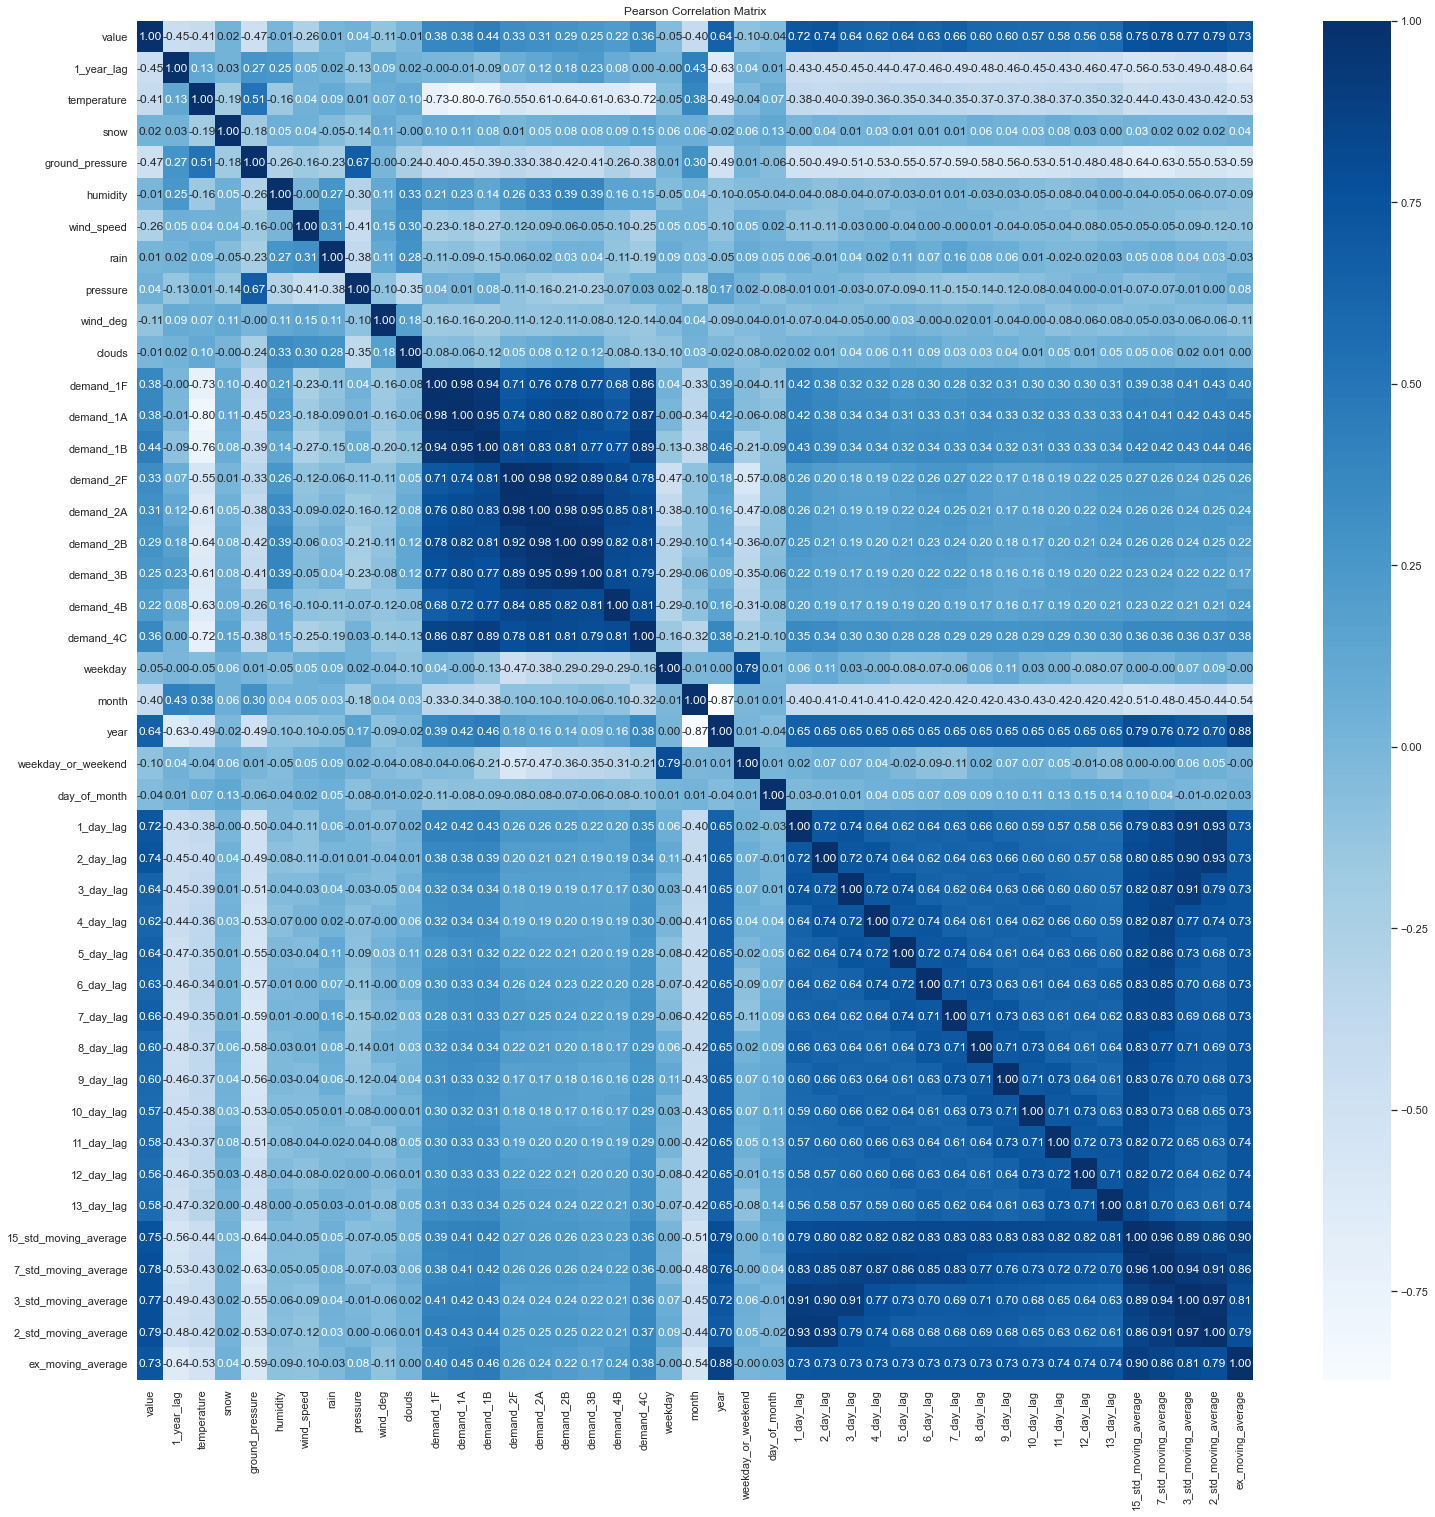

In [37]:
# Plot Pearson correlation matrix
correlations = data.corr(method='pearson')
plt.subplots(figsize=(25,25))
cmap= sns.color_palette("Blues", as_cmap=True)
sns.heatmap(correlations, annot=True, fmt='.2f', cmap=cmap)
plt.title('Pearson Correlation Matrix')
plt.savefig('Plots/correlation1.png', bbox_inches='tight')

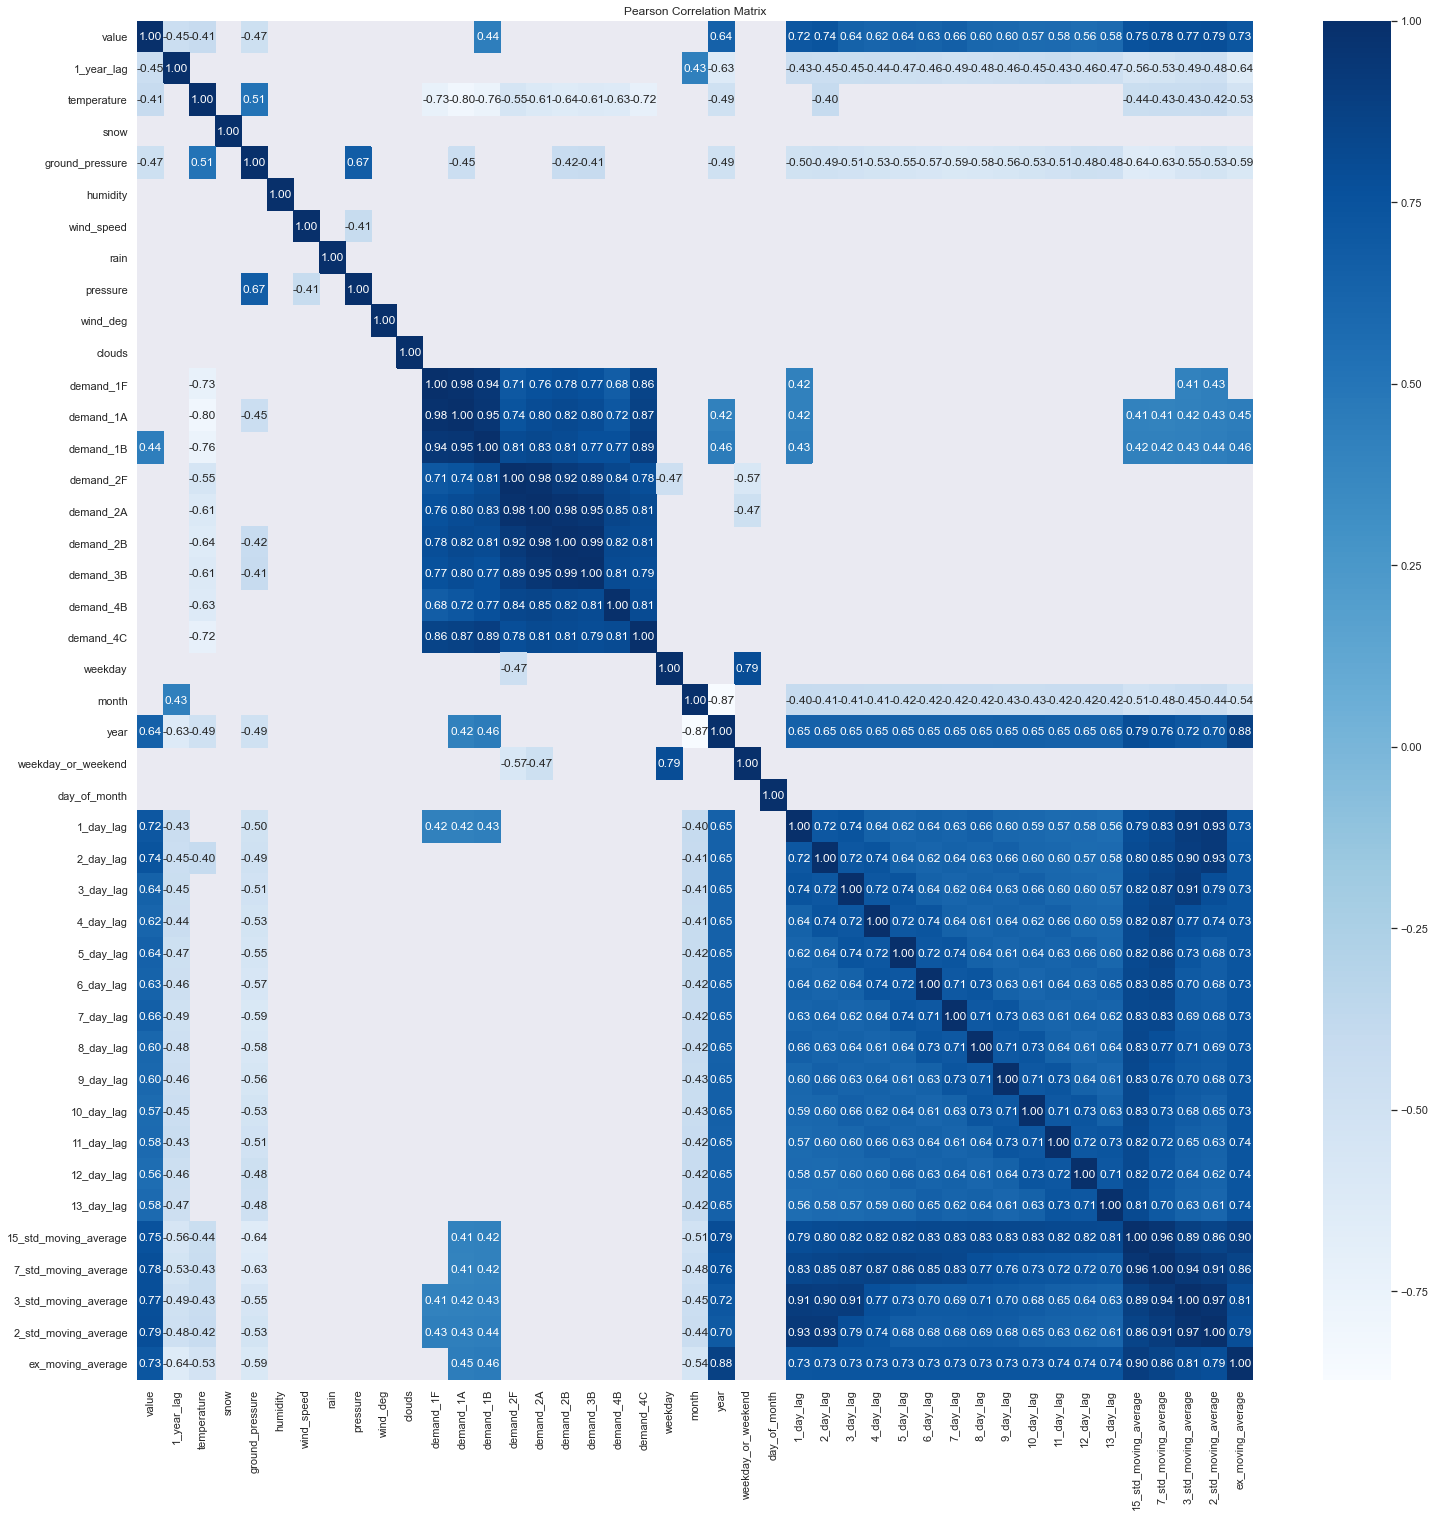

In [38]:
# Print features that are highly correlated to each other
highly_correlated = correlations[abs(correlations) > 0.4]
#print(highly_correlated[highly_correlated < 1.0].stack().to_string())
plt.subplots(figsize=(25,25))
sns.heatmap(highly_correlated, annot=True, fmt='.2f', cmap=cmap)
plt.title('Pearson Correlation Matrix')
plt.savefig('Plots/correlation2.png', bbox_inches='tight')

In [39]:
# Stationarity check with ADF test
dftest = adfuller(data['value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.115916
p-value                          0.238163
#Lags Used                       6.000000
Number of Observations Used    353.000000
Critical Value (1%)             -3.449011
Critical Value (5%)             -2.869763
Critical Value (10%)            -2.571151
dtype: float64


In [40]:
# Apply difference transform to make data stationary
data['diff_value'] = data['value'] - data['1_day_lag']

In [41]:
# Stationarity check with ADF test
dftest = adfuller(data['diff_value'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.289513e+01
p-value                        4.364908e-24
#Lags Used                     5.000000e+00
Number of Observations Used    3.540000e+02
Critical Value (1%)           -3.448958e+00
Critical Value (5%)           -2.869739e+00
Critical Value (10%)          -2.571138e+00
dtype: float64


## Modelling

#### Split dates into training and test data

In [42]:
# Function to split into training and test set the number of dates
def divide_time_df(dataframe, proportion):
    num_dates = dataframe.shape[0]
    head = round(num_dates * proportion, 0)
    tail = num_dates - head 
    print('Total days are {}'.format(data.shape[0]))
    print('Head is {}'.format(head))
    print('Tail is {}'.format(tail))
    return head,tail

In [43]:
# Divide the dates into first 80% and last 20%
head, tail = divide_time_df(data, 0.8)
data_train = data.head(int(head))
data_test = data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

Total days are 360
Head is 288.0
Tail is 72.0


## Non-Stationary Models

## Random Forest model Non-Stationary

#### Convert data into training and test arrays for Random Forest

In [44]:
# Train data removing the string columns and the value and diff_value
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name','year'], axis=1).values
y_train = data_train.value.values

# Test data removing the string columns and the value and diff_value
X_test = data_test.drop(['value', 'diff_value', 'start_time_uk','month_name','weekday_name','year'], axis=1).values
y_test = data_test.value.values

In [45]:
train_df = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name','year'], axis=1)

#### Grid search for best parameters

In [46]:
# Array with all data
X = data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1).values
y = data.value.values

In [47]:
def expanding_window(n, test_size, X, y, n_estimators, min_samples_split, 
                               min_samples_leaf, max_depth, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        X_train = X[:initial_train]
        X_test = X[initial_train:initial_train + test_size]
        y_train = y[:initial_train]
        y_test = y[initial_train:initial_train + test_size]
        
        forest = RandomForestRegressor(n_estimators=n_estimators, min_samples_split= min_samples_split, 
                               min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=0)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)
        
        score.append(metrics.r2_score(y_test,y_hat))
        
        if plot == True:
            #plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            #plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            #plt.legend()
            #plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            #plt.show()
            print('R2 are {}'.format(score))
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score))

In [160]:
print("Size of training set: {} size of test set: {}".format(
          X_train.shape[0], X_test.shape[0]))

RF_best_score = -11
for n_estimators in [10, 20, 50,100]: 
    for max_depth in [5,7,9,10,15,50]:
        for min_samples_split in [2,3,4]:
            for min_samples_leaf in [1,2,3,4]:
                # for each combination of parameters, train a model
                # evaluate the forest on the test set
                score = expanding_window(3, 20, X_train, y_train, n_estimators, 
                                         min_samples_split, min_samples_leaf, max_depth, False)
                # if we got a better score, store the score and parameters 
                if score > RF_best_score:
                    RF_best_score = score
                    RF_best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        
print("Best score: {:.2f}".format(RF_best_score)) 
print("Best parameters: {}".format(RF_best_parameters))

Size of training set: 288 size of test set: 72
Best score: -0.59
Best parameters: {'n_estimators': 20, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1}


#### Making and fitting Random Forest model with chosen parameters

In [48]:
forest = RandomForestRegressor(n_estimators=40, min_samples_split= 2, 
                               min_samples_leaf=2, max_depth=5, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

#### Random Forest model evaluation

In [49]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.822
Accuracy on test set: -3.031


In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [53]:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

Accuracy on training set: 0.822
Accuracy on test set: -3.031
R2 is -3.030975549441976
The mean absolute error is 17.52371252753883
The root mean squared error is 415.2430795250445
The mean absolute percentage error is 21.25052421659283


In [48]:
expanding_window(3, 20, X, y, n_estimators, min_samples_split, min_samples_leaf, max_depth, False)

NameError: name 'n_estimators' is not defined

#### Plotting predicted and real values for the Random Forest

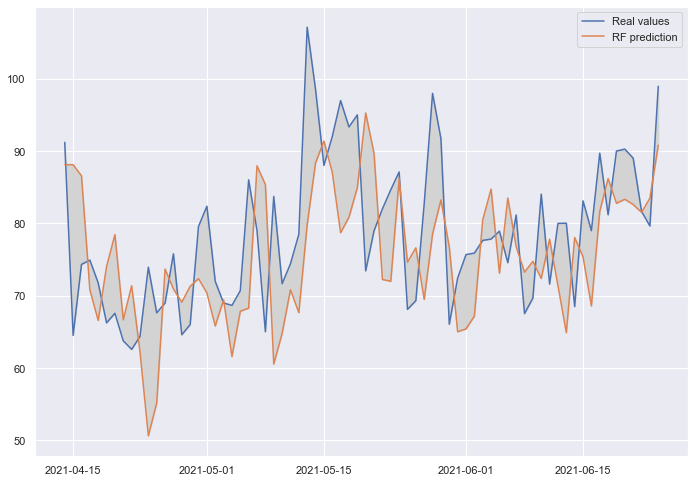

In [59]:
plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/4rf_plot.png', bbox_inches='tight')



Feature 1_year_lag , Score: 0.00214
Feature temperature , Score: 0.04539
Feature snow , Score: 0.00000
Feature ground_pressure , Score: 0.00832
Feature humidity , Score: 0.00407
Feature wind_speed , Score: 0.00970
Feature rain , Score: 0.00092
Feature pressure , Score: 0.00060
Feature wind_deg , Score: 0.00458
Feature clouds , Score: 0.00155
Feature demand_1F , Score: 0.01821
Feature demand_1A , Score: 0.01570
Feature demand_1B , Score: 0.09792
Feature demand_2F , Score: 0.02309
Feature demand_2A , Score: 0.05005
Feature demand_2B , Score: 0.02840
Feature demand_3B , Score: 0.01829
Feature demand_4B , Score: 0.04455
Feature demand_4C , Score: 0.01040
Feature weekday , Score: 0.00086
Feature month , Score: 0.00699
Feature weekday_or_weekend , Score: 0.00011
Feature day_of_month , Score: 0.00289
Feature 1_day_lag , Score: 0.03621
Feature 2_day_lag , Score: 0.02362
Feature 3_day_lag , Score: 0.00794
Feature 4_day_lag , Score: 0.00443
Feature 5_day_lag , Score: 0.01608
Feature 6_day_lag , 

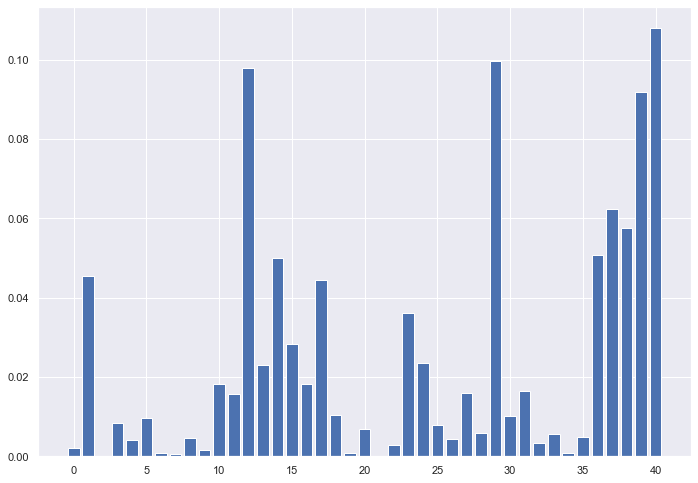

In [55]:
# Feature selection
importance = forest.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature ' + train_df.columns[i] + ' , Score: %.5f' % (v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

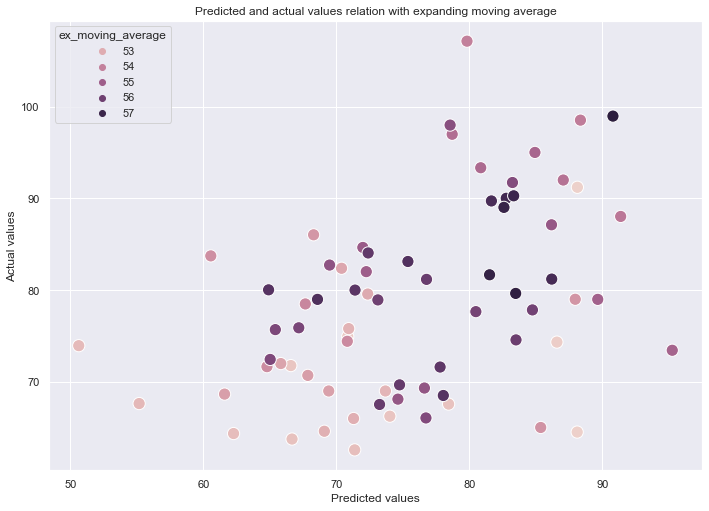

In [58]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/4rf_scatter.png', bbox_inches='tight')

##### Plotting predicted and real values with some features

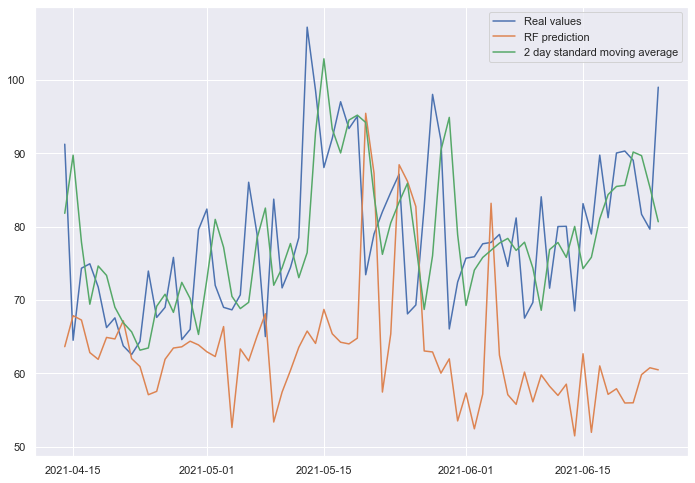

In [142]:
plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.plot(data_test.index, data_test['2_std_moving_average'], label='2 day standard moving average')
plt.legend()

In [143]:
sns.scatterplot(x=y_test, y=y_hat, hue='5_std_moving_average', data=data_test)

ValueError: Could not interpret value `5_std_moving_average` for parameter `hue`

### Creating the PCA Random Forest model Non-Stationary

#### Random Forest, but first applying PCA and standarising

Original shape: (360, 42)
Reduced shape: (360, 2)
X train shape: (288, 2)
X test shape: (72, 2)
y train shape: (288,)
y test shape: (72,)
Accuracy on training set: 0.842
Accuracy on test set: -4.065
R2 is -4.064839707067442
The mean absolute error is 19.665563440546507
The root mean squared error is 521.7445780723117
The mean absolute percentage error is 24.18899539331076


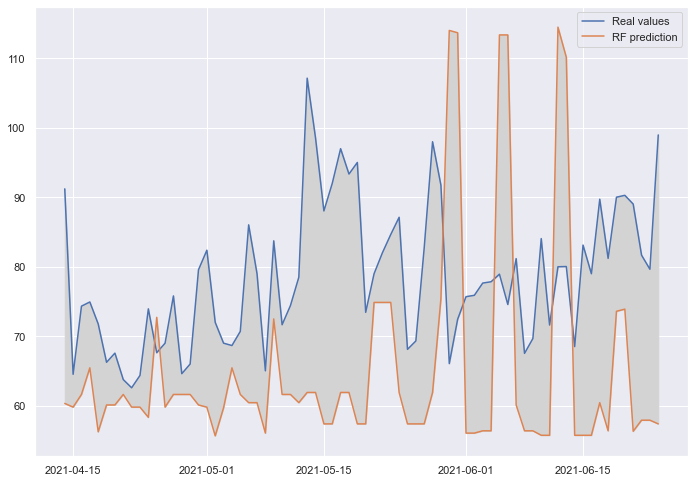

In [144]:
#We first scale the data
from sklearn.preprocessing import StandardScaler

X = data.drop(['value', 'diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y = data.value.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Reducing feature dimensionality with PCA
from sklearn.decomposition import PCA
#keep the first two principal components of the data 
pca = PCA(n_components=2)
pca.fit(X_scaled)
#transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

X_train = X_pca[:int(head)]
X_test = X_pca[len(X_pca)-int(tail):len(X_pca)]
y_train = y[:int(head)]
y_test = y[len(X_pca)-int(tail):len(X_pca)]

print("X train shape: {}".format(X_train.shape)) 
print("X test shape: {}".format(X_test.shape))
print("y train shape: {}".format(y_train.shape)) 
print("y test shape: {}".format(y_test.shape))

forest = RandomForestRegressor(n_estimators=12, max_depth=7, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')

### Lasso model Non-Stationary

In [145]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.value.values

R2 is -0.12293202484114385
The mean absolute error is 9.059487745049864
The root mean squared error is 115.67665106698071
The mean absolute percentage error is 11.553584490056199
Accuracy on training set: 0.693
Accuracy on test set: -0.123


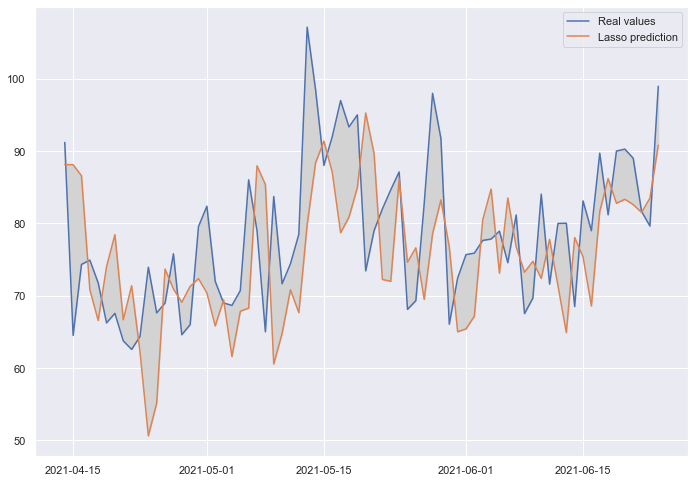

In [57]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, max_iter=5000000)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

print("Accuracy on training set: {:.3f}".format(lasso.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(lasso.score(X_test, y_test)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Lasso prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/4lasso_plot.png', bbox_inches='tight')

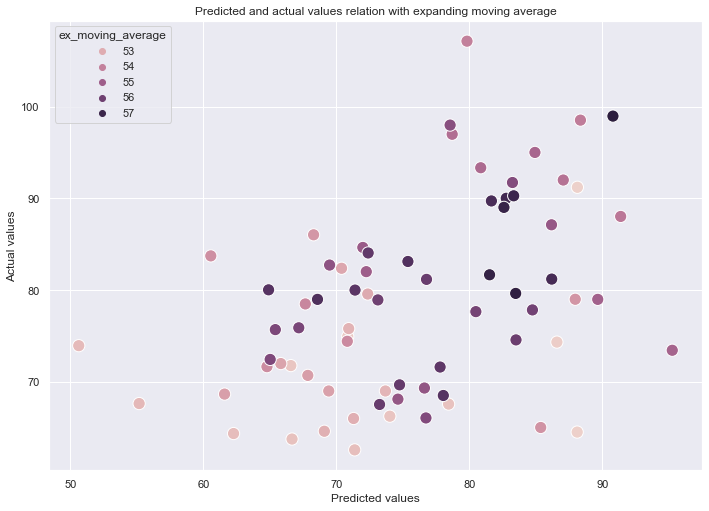

In [60]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/4lasso_scatter.png', bbox_inches='tight')

## Elastic Model Non-Stationary Time Series

Accuracy on training set: 0.692
Accuracy on test set: -0.127
R2 is -0.12672147387653476
The mean absolute error is 9.05139064315589
The root mean squared error is 116.06701376401487
The mean absolute percentage error is 11.54501223619274


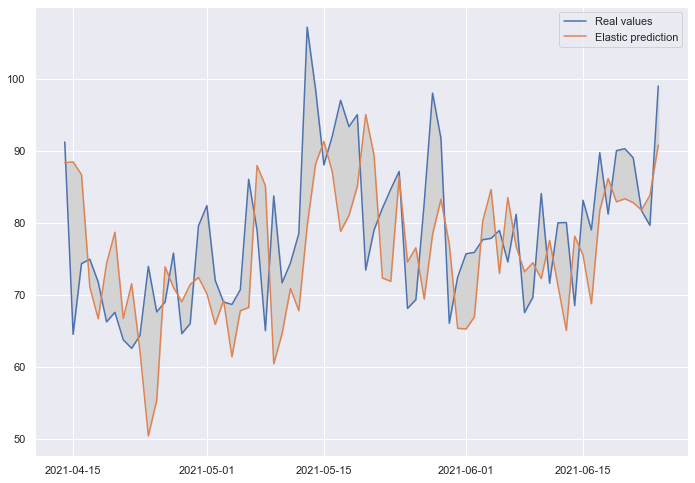

In [61]:
# Create the elastic model
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.001, l1_ratio=0.7, max_iter=5000000)
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(enet.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(enet.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test, y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test, y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test, y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test, y_hat)))

plt.plot(data_test.index,  y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Elastic prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/4elast_plot.png', bbox_inches='tight')


plt.show()

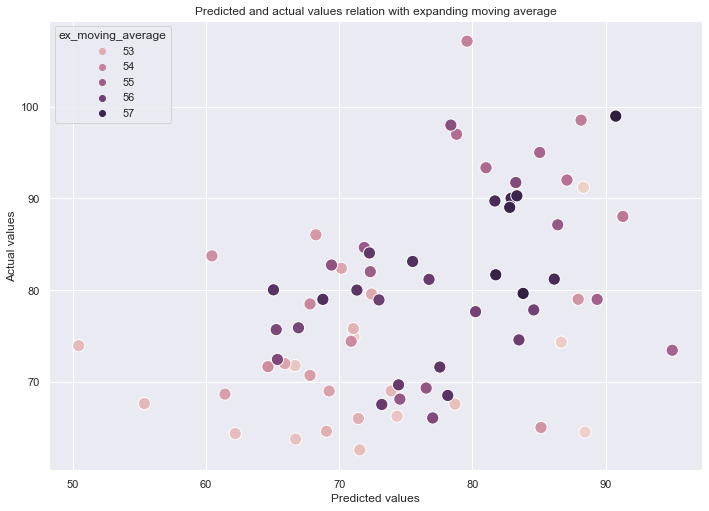

In [62]:
sns.scatterplot(x=y_hat, y=y_test, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/4elast_scatter.png', bbox_inches='tight')

# Applying models to Stationary Time Series

#### Redefining all the data

In [63]:
# New dataframe with differenciated features and value, change all the old columns for new ones
diff_data = data.copy()
for i in range(1,14):
    add_lag_feature(i, 'diff_value', diff_data)
    
# Need to be better to not include diff_value itself
add_standard_moving_average(15,'1_day_lag',diff_data)
add_standard_moving_average(7,'1_day_lag',diff_data)
add_standard_moving_average(3,'1_day_lag',diff_data)
add_standard_moving_average(2,'1_day_lag',diff_data)
add_expanding_moving_average('1_day_lag',diff_data)

# Dividing the dataframe into test and trining sets.
head, tail = divide_time_df(diff_data, 0.8)
data_train = diff_data.head(int(head))
data_test = diff_data.tail(int(tail))
data_train.index = pd.DatetimeIndex(data_train.index.values,
                               freq=data_train.index.inferred_freq)

# Original data train/test
original_data_train = data.head(int(head))
original_data_test = data.tail(int(tail))

# Converting the dataframes to arrays for sklearn
X_train = data_train.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.diff_value.values
X_test = data_test.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.diff_value.values

#Original data train/test
original_lag = original_data_test['1_day_lag'].values

features_names = diff_data.drop(['diff_value','value','start_time_uk','month_name','weekday_name'], axis=1).columns

Total days are 360
Head is 288.0
Tail is 72.0


## Random Forest Stationary Time Series

#### Grid search for best parameters (later improved to be tested in training)

In [64]:
# Array with all data
X = diff_data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1).values
y = diff_data.value.values

In [65]:
def diff_expanding_window(n, test_size, X, y, n_estimators, min_samples_split, 
                               min_samples_leaf, max_depth, plot):
    """
    This functions evaluates a model with a expanding window method.
    """
    total_size = X.shape[0]
    score = []
    initial_train = total_size - test_size*n
    for i in range(1,n+1):
        X_train = X[:initial_train]
        X_test = X[initial_train:initial_train + test_size]
        y_train = y[:initial_train]
        y_test = y[initial_train:initial_train + test_size]
        original_lag = data.drop(['value','diff_value','start_time_uk',
               'month_name','weekday_name'], axis=1)['1_day_lag'].values[initial_train:initial_train + test_size]
        
        forest = RandomForestRegressor(n_estimators=n_estimators, min_samples_split= min_samples_split, 
                               min_samples_leaf=min_samples_leaf, max_depth=max_depth, random_state=0)
        forest.fit(X_train, y_train)
        y_hat = forest.predict(X_test)
        
        score.append(metrics.r2_score(y_test + original_lag,y_hat + original_lag))
        
        if plot == True:
            #plt.plot(range(y_test.shape[0]), y_test, label='Real values')
            #plt.plot(range(y_test.shape[0]), y_hat, label='RF prediction')
            #plt.legend()
            #plt.fill_between(range(y_test.shape[0]), y_test, y_hat, color='lightgrey')
            plt.show()
            #print('R2 are {}'.format(score))
        
        initial_train = initial_train + test_size
        
    #print('R2 are {}'.format(score))    
    return(np.mean(score))

In [53]:
print("Size of training set: {} size of test set: {}".format(
          X_train.shape[0], X_test.shape[0]))

RF_best_score = -11
for n_estimators in [10, 20, 50,100]: 
    for max_depth in [5,7,9,10,15,50]:
        for min_samples_split in [2,3,4]:
            for min_samples_leaf in [1,2,3,4]:
                # for each combination of parameters, train a model
                # evaluate the forest on the test set
                score = diff_expanding_window(5, 30, X_train, y_train, n_estimators, 
                                         min_samples_split, min_samples_leaf, max_depth, False)
                # if we got a better score, store the score and parameters 
                if score > RF_best_score:
                    RF_best_score = score
                    RF_best_parameters = {'n_estimators': n_estimators, 'max_depth': max_depth,
                                         'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
        
print("Best score: {:.2f}".format(RF_best_score)) 
print("Best parameters: {}".format(RF_best_parameters))

Size of training set: 288 size of test set: 72
Best score: -0.01
Best parameters: {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 2}


Accuracy on training set: 0.767
Accuracy on test set: 0.181
R2 is 0.18776468152639625
The mean absolute error is 6.866426493528686
The root mean squared error is 83.6708362045696
The mean absolute percentage error is 8.595079589044781


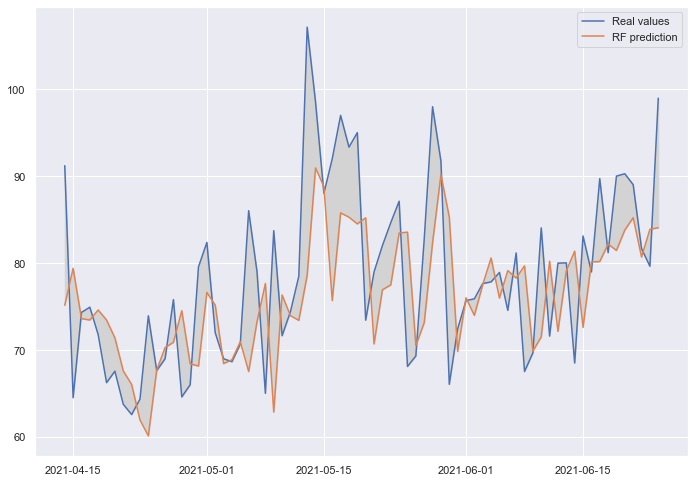

In [67]:
# Create the random forest model
forest = RandomForestRegressor(n_estimators=100, max_depth=9, min_samples_split=2, min_samples_leaf=2, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test + original_lag,y_hat + original_lag)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test + original_lag, y_hat + original_lag)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test + original_lag, y_hat + original_lag)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test + original_lag, y_hat + original_lag)))

#print(diff_expanding_window(10, 10, X, y, n_estimators, min_samples_split, min_samples_leaf, max_depth, True))

plt.plot(data_test.index,  y_test + original_lag, label='Real values')
plt.plot(data_test.index, y_hat + original_lag, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test + original_lag, y_hat + original_lag, color='lightgrey')
plt.savefig('Plots/4rf_stst_plot.png', bbox_inches='tight')

plt.show()

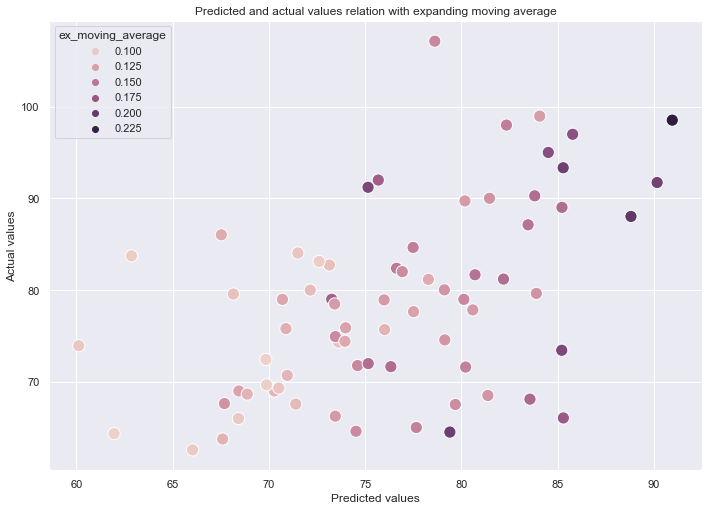

In [68]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/4rf_stst_scatter_ex.png', bbox_inches='tight')

#### Feature importance of the Differentiated Random Forest Model

Feature 1_year_lag , Score: 0.00841
Feature temperature , Score: 0.00233
Feature snow , Score: 0.00000
Feature ground_pressure , Score: 0.00481
Feature humidity , Score: 0.01322
Feature wind_speed , Score: 0.03030
Feature rain , Score: 0.00175
Feature pressure , Score: 0.00365
Feature wind_deg , Score: 0.00862
Feature clouds , Score: 0.00284
Feature demand_1F , Score: 0.01738
Feature demand_1A , Score: 0.01266
Feature demand_1B , Score: 0.03144
Feature demand_2F , Score: 0.03713
Feature demand_2A , Score: 0.01934
Feature demand_2B , Score: 0.00396
Feature demand_3B , Score: 0.01569
Feature demand_4B , Score: 0.00842
Feature demand_4C , Score: 0.00849
Feature weekday , Score: 0.00482
Feature month , Score: 0.00278
Feature year , Score: 0.00032
Feature weekday_or_weekend , Score: 0.00193
Feature day_of_month , Score: 0.00557
Feature 1_day_lag , Score: 0.19613
Feature 2_day_lag , Score: 0.01270
Feature 3_day_lag , Score: 0.00480
Feature 4_day_lag , Score: 0.00912
Feature 5_day_lag , Score

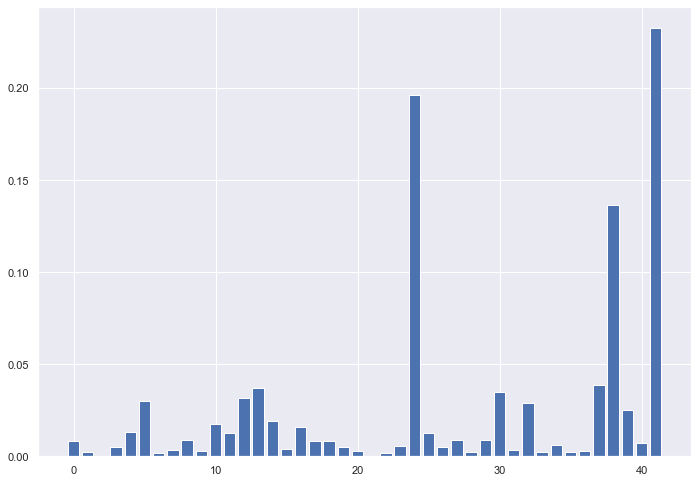

{'1_year_lag': 0.008410249330560553, 'temperature': 0.002331840434021368, 'snow': 0.0, 'ground_pressure': 0.004810986109069557, 'humidity': 0.013222411907488745, 'wind_speed': 0.030296051843647587, 'rain': 0.0017518562587086409, 'pressure': 0.003648124698532124, 'wind_deg': 0.008620301570589966, 'clouds': 0.002839001564611181, 'demand_1F': 0.017377423401489678, 'demand_1A': 0.012657280987581903, 'demand_1B': 0.03144034745236236, 'demand_2F': 0.037126620064568946, 'demand_2A': 0.01934431740210769, 'demand_2B': 0.003963291506174754, 'demand_3B': 0.015685236400119096, 'demand_4B': 0.008419416830773152, 'demand_4C': 0.00849149584189216, 'weekday': 0.0048154916671455696, 'month': 0.0027758405828587625, 'year': 0.0003219010537131261, 'weekday_or_weekend': 0.0019319796635781693, 'day_of_month': 0.005566175352982614, '1_day_lag': 0.1961268000352753, '2_day_lag': 0.012695816398224488, '3_day_lag': 0.0047966712658394205, '4_day_lag': 0.009115560324705306, '5_day_lag': 0.0022539773838798857, '6_d

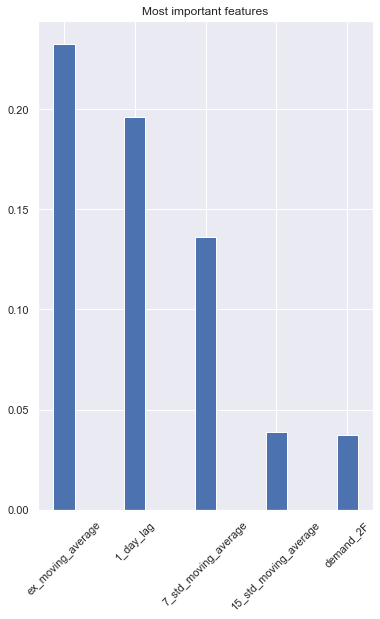

In [69]:
# Feature selection
importance = forest.feature_importances_
# summarize feature importance
features_dic={}
for i,v in enumerate(importance):
    print('Feature ' + features_names[i] + ' , Score: %.5f' % (v))
    features_dic[features_names[i]]= v
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
print(features_dic)
five_keys = sorted(features_dic, key=features_dic.get, reverse=True)[:5]
print(five_keys)
most_used = {key: features_dic[key] for key in five_keys}
plt.figure(figsize=(6,9))
plt.bar(most_used.keys(), most_used.values(), width=0.3)
plt.xticks(rotation=45)
plt.title('Most important features')
plt.savefig('Plots/4cycle.png', bbox_inches='tight')

### Creating the PCA Random Forest model Stationary Time Series

Original shape: (360, 42)
Reduced shape: (360, 2)
X train shape: (288, 2)
X test shape: (72, 2)
y train shape: (288,)
y test shape: (72,)
Accuracy on training set: 0.821
Accuracy on test set: -9.137
R2 is -9.13683084515273
The mean absolute error is 30.37000784077591
The root mean squared error is 1044.2258468544624
The mean absolute percentage error is 37.81085407094906


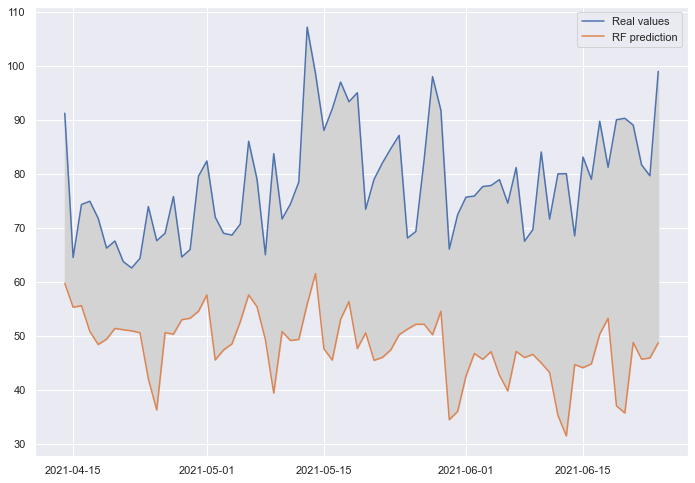

In [154]:
#We first scale the data
from sklearn.preprocessing import StandardScaler

X = diff_data.drop(['value', 'diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y = diff_data.value.values

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

#Reducing feature dimensionality with PCA
from sklearn.decomposition import PCA
#keep the first two principal components of the data 
pca = PCA(n_components=2)
pca.fit(X_scaled)
#transform data onto the first two principal components
X_pca = pca.transform(X_scaled)

print("Original shape: {}".format(str(X_scaled.shape))) 
print("Reduced shape: {}".format(str(X_pca.shape)))

X_train = X_pca[:int(head)]
X_test = X_pca[len(X_pca)-int(tail):len(X_pca)]
y_train = y[:int(head)]
y_test = y[len(X_pca)-int(tail):len(X_pca)]

print("X train shape: {}".format(X_train.shape)) 
print("X test shape: {}".format(X_test.shape))
print("y train shape: {}".format(y_train.shape)) 
print("y test shape: {}".format(y_test.shape))

forest = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)
forest.fit(X_train, y_train)
y_hat = forest.predict(X_test)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')

### Lasso model Stationary Time Series

In [155]:
X_train = data_train.drop(['value','diff_value','start_time_uk','month_name','weekday_name'], axis=1).values
y_train = data_train.value.values

X_test = data_test.drop(['value','diff_value', 'start_time_uk','month_name','weekday_name'], axis=1).values
y_test = data_test.value.values

R2 is -0.32755279825256767
The mean absolute error is 8.779186047827745
The root mean squared error is 135.60234338470278
The mean absolute percentage error is 540.8093561964315
Accuracy on training set: 0.601
Accuracy on test set: -0.328


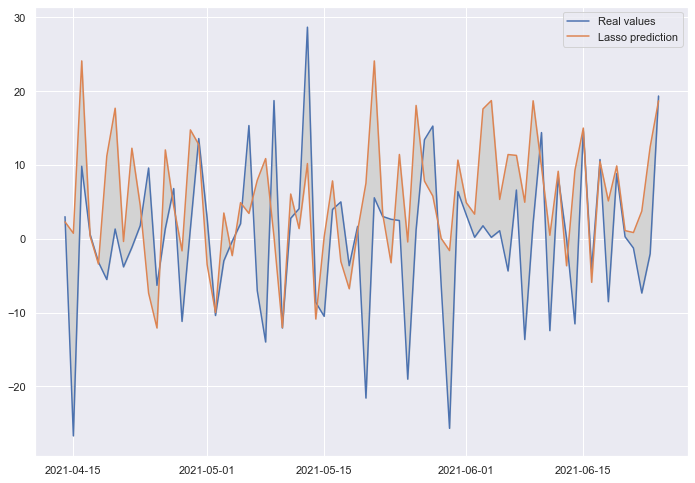

In [70]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, max_iter=5000000)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)

# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test,y_hat)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test,y_hat)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test,y_hat)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test,y_hat)))

print("Accuracy on training set: {:.3f}".format(lasso.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(lasso.score(X_test, y_test)))

plt.plot(data_test.index, y_test, label='Real values')
plt.plot(data_test.index, y_hat, label='Lasso prediction')
plt.legend()
plt.fill_between(data_test.index, y_test, y_hat, color='lightgrey')
plt.savefig('Plots/4lasso_stst_plot.png', bbox_inches='tight')

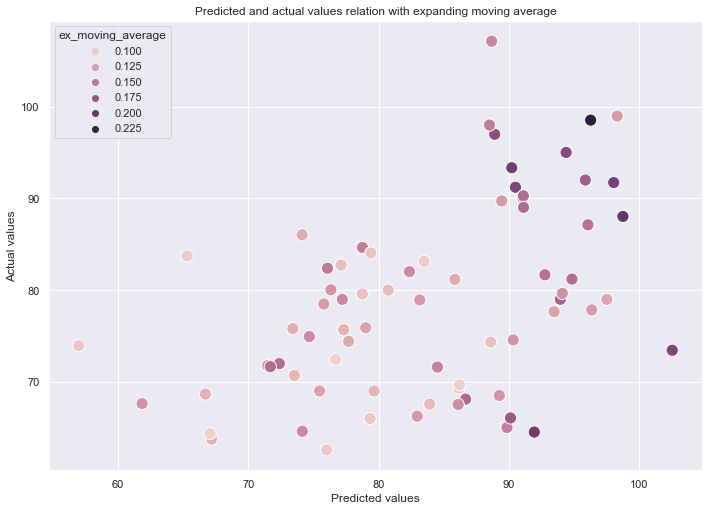

In [71]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/4lasso_stst_scatter_ex.png', bbox_inches='tight')

### Elastic Model Stationary Time Series

In [74]:
# Create the elastic model
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.001, l1_ratio=0.7, max_iter=5000000)
enet.fit(X_train, y_train)
y_hat = enet.predict(X_test)

# Pint all the scores:
print("Accuracy on training set: {:.3f}".format(enet.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(enet.score(X_test, y_test)))
# Scores:
# R^2
print('R2 is {}'
      .format(metrics.r2_score(y_test + original_lag,y_hat + original_lag)))
# MAE
print('The mean absolute error is {}'
      .format(metrics.mean_absolute_error(y_test + original_lag, y_hat + original_lag)))
# RMSE
print('The root mean squared error is {}'
      .format(metrics.mean_squared_error(y_test + original_lag, y_hat + original_lag)))
#MAPE
print('The mean absolute percentage error is {}'
      .format(mean_absolute_percentage_error(y_test + original_lag, y_hat + original_lag)))

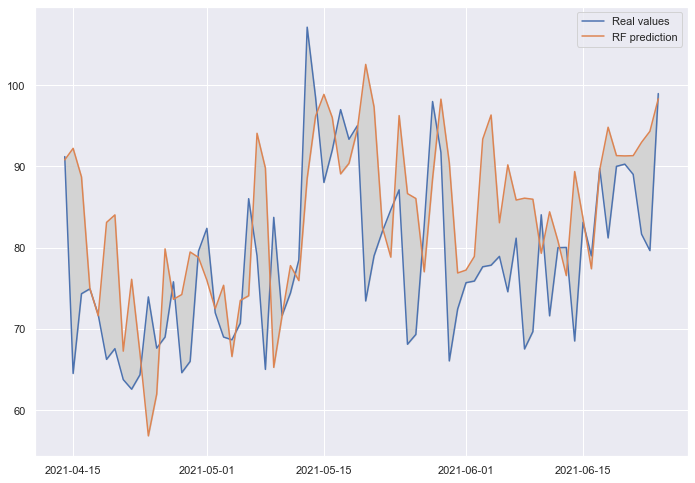

In [75]:
plt.plot(data_test.index,  y_test + original_lag, label='Real values')
plt.plot(data_test.index, y_hat + original_lag, label='RF prediction')
plt.legend()
plt.fill_between(data_test.index, y_test + original_lag, y_hat + original_lag, color='lightgrey')
plt.savefig('Plots/4elastic_stst_plot.png', bbox_inches='tight')
plt.show()

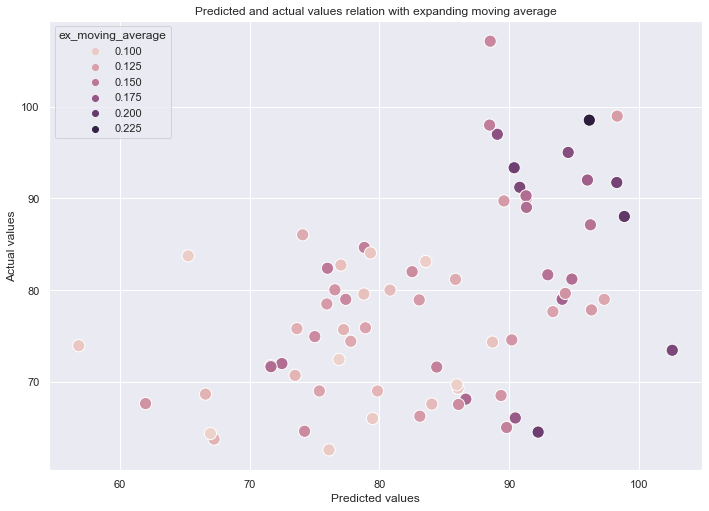

In [73]:
sns.scatterplot(x=y_hat+ original_lag, y=y_test+ original_lag, hue='ex_moving_average', data=data_test, s=150)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted and actual values relation with expanding moving average')
plt.savefig('Plots/4elastic_stst_scatter_ex.png', bbox_inches='tight')

#### Summary of the model to see certain features (code in Notebook 4)

#### Making features cyclic

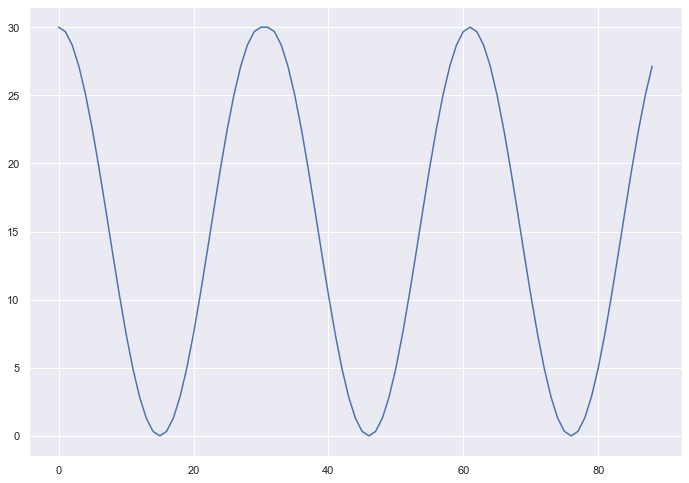

In [298]:
def sin_transform(day_of_month):
    return(np.sin((2*np.pi)/30*day_of_month))
def cos_transform(day_of_month):
    return(np.cos((2*np.pi)/30*day_of_month))

day_of_month = []
for i in range(31):
    day_of_month.append(15*cos_transform(i)+15)
for i in range(30):
    day_of_month.append(15*cos_transform(i)+15)
for i in range(28):
    day_of_month.append(15*cos_transform(i)+15)


day_of_year = range(len(day_of_month))
plt.plot(day_of_year, day_of_month)
